### The First cell will always contains the libraries that i used to solve different problems so that it is organized


In [429]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer



### Data Exploration

In [430]:
def read_diff_files(data_dir, train_file, test_file,sample_submission):
    current_directory = os.getcwd()
    path_to_data = current_directory + data_dir  
    df_train = pd.read_csv(path_to_data + train_file)
    df_test = pd.read_csv(path_to_data+test_file)
    df_sam_subm = pd.read_csv(path_to_data+sample_submission)  
    return df_train,df_test,df_sam_subm

df_train,df_test,df_sam_subm = read_diff_files(data_dir = "/Data",train_file = "/train.csv", test_file ="/test.csv", sample_submission = "/sample_submission.csv")

### Check Null Values
1. Check the percentage of missing values and what columns 
2. See the importance of that columns 
3. Check Imputation Method
4. Do Visulatizations    

In [431]:
def data_explortation(dataframe):
    print("------------This is different dataset Info ---------------")
    print(dataframe.info())
    print("---------------------------------------------------------")
    null_counts = dataframe.isnull().sum()
    null_percentage = (null_counts/len(dataframe))* 100
    columns_with_null_percentage = null_percentage[null_percentage > 0]
    print("----------Those are the columns with null values and the percentage-------------")
    print(columns_with_null_percentage)
    print("-------------------------------------------------------------------")
    print("----------Those are the Data types in the training dataset-------------")
    data_types = list(set(dataframe.dtypes.tolist())) 
    print(data_types)
    print("-------------------------------------------------------------------")
    print("--------------This is the size of the Dataframe----------------")
    print(dataframe.shape)
    print("-----------------------------------------------------------------")

    return columns_with_null_percentage, data_types 
    # Filter columns with null values
cols_with_null_perc,date_types_df = data_explortation(df_train)    


------------This is different dataset Info ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object

### Check missing values and how to handle them

In [432]:
def features_types(data_frame):
    categorical_features = data_frame.select_dtypes(include=['object'])
    numeric_features = data_frame.select_dtypes(include=['int64'])
    float_features = data_frame.select_dtypes(include=['float64'])

    num_of_categorial_features = categorical_features.shape[1]
    num_of_numeric_features = numeric_features.shape[1]
    num_of_float_features = float_features.shape[1]
    
    print(f"Number of categorial features:{num_of_categorial_features} ")
    print(f"Number of numeric features:{num_of_numeric_features}")
    print(f"num_of_float_features:{num_of_float_features}")
    return categorical_features,numeric_features,float_features
categorical_features,numeric_features,float_features = features_types(df_train)    


Number of categorial features:43 
Number of numeric features:35
num_of_float_features:3


### Check the missing values according the feature type
 

In [433]:
def check_missing_vlaues_per_data_type(feature_type_df,datatype):
    print(f"The number of nulls in {datatype} ")
    #print(feature_type_df.isnull().sum())
    null_counts = feature_type_df.isnull().sum()
    null_percentage = (null_counts/len(feature_type_df))* 100
    columns_with_null_percentage = null_percentage[null_percentage > 0].sort_values(ascending=False)
    print(columns_with_null_percentage)

check_missing_vlaues_per_data_type(categorical_features,"categorical")
print("--------------------------------------------------------------")
check_missing_vlaues_per_data_type(numeric_features,"Numeric")
print("--------------------------------------------------------------")
check_missing_vlaues_per_data_type(float_features, "Float")

The number of nulls in categorical 
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
--------------------------------------------------------------
The number of nulls in Numeric 
Series([], dtype: float64)
--------------------------------------------------------------
The number of nulls in Float 
LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64


### From the above info we can conclude that
1. The most missing info is from the categorical Features, the feature with most missing values has missing vales percntage of 99.5%
2. There are no missing info from numeric features, 
3. There are missing info from float but not that big, he feature with most missing values has missing vales percntage of 17.7%

### Now we need to handle the missing values and decide the imputation methods
1. First the categorial values above 40% missing values are gonna be dropped
2. That leaves us with the rest of the features to impute
3. To know how to handle them, we need to Know which type of missing values that they belong to

### Types of Misiing values are Missing completely at random(Mcar), Missing at random(MAR), Not missing at random(NMAR)

In [434]:
def drop_features(df, threshold):
    null_counts = df.isnull().sum()
    null_percentage = (null_counts/len(df))* 100
    features_to_remove = null_percentage[null_percentage > 40].index.tolist()
    df = df.drop(features_to_remove, axis=1)
    return df

print(" Number of features in the Originial train_data:", df_train.shape[1])
df_train = drop_features(df_train,40)
print(" Number of features in the train_data After dropping features with missing values above 40%:", df_train.shape[1])
print("----------------------------------------------")
print(" Number of features in the Originial Test data:", df_test.shape[1])
df_test = drop_features(df_test,40)
print(" Number of features in the test data After dropping features with missing values greater than 40%:", df_test.shape[1])
print("----------------------------------------------")



 Number of features in the Originial train_data: 81
 Number of features in the train_data After dropping features with missing values above 40%: 76
----------------------------------------------
 Number of features in the Originial Test data: 80
 Number of features in the test data After dropping features with missing values greater than 40%: 75
----------------------------------------------


In [406]:
categorical_features,numeric_features,float_features = features_types(df_train)
categorical_features_test,numeric_features_test,float_features_test = features_types(df_test)

Number of categorial features:38 
Number of numeric features:35
num_of_float_features:3
Number of categorial features:38 
Number of numeric features:26
num_of_float_features:11


In [220]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

### With the help of visualization, we can recognize the missing value type

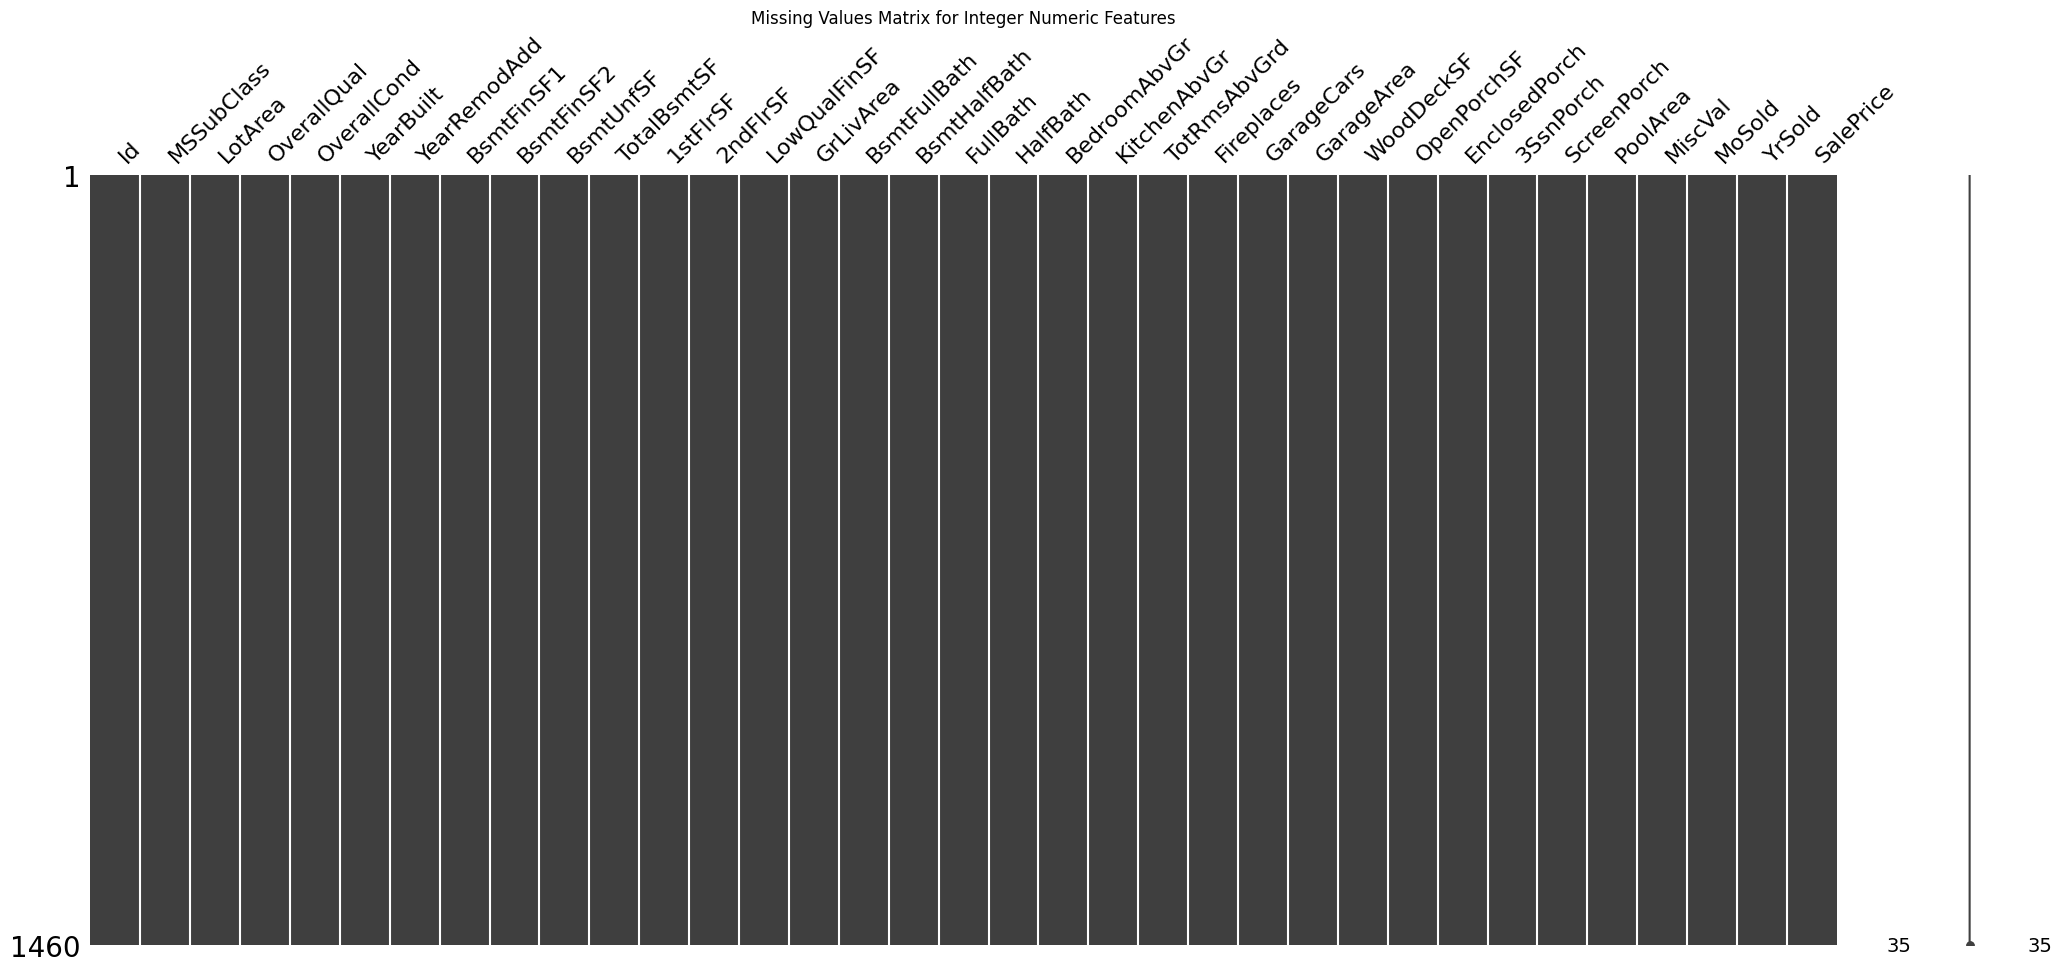

In [388]:
msno.matrix(numeric_features)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

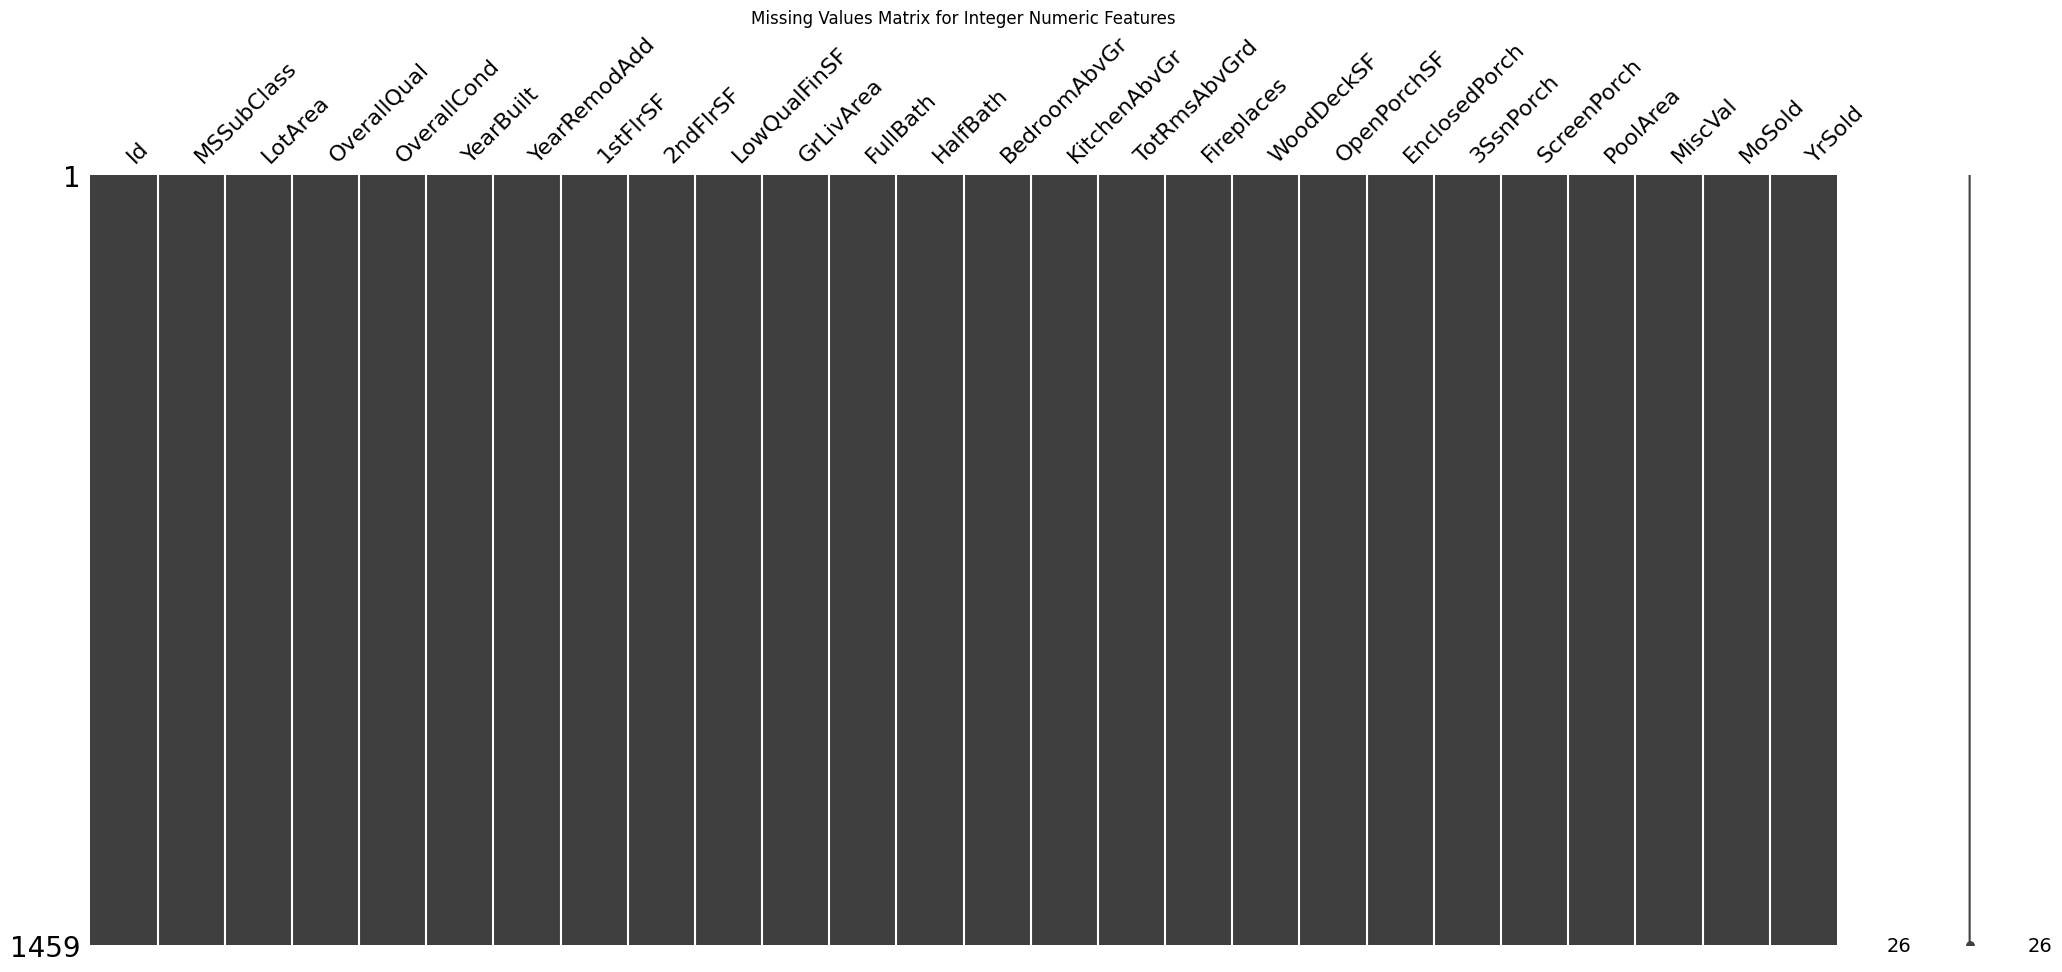

In [389]:
msno.matrix(numeric_features_test)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

### As we can see all there are no gaps in the numeric features, There are no gaps in the line 

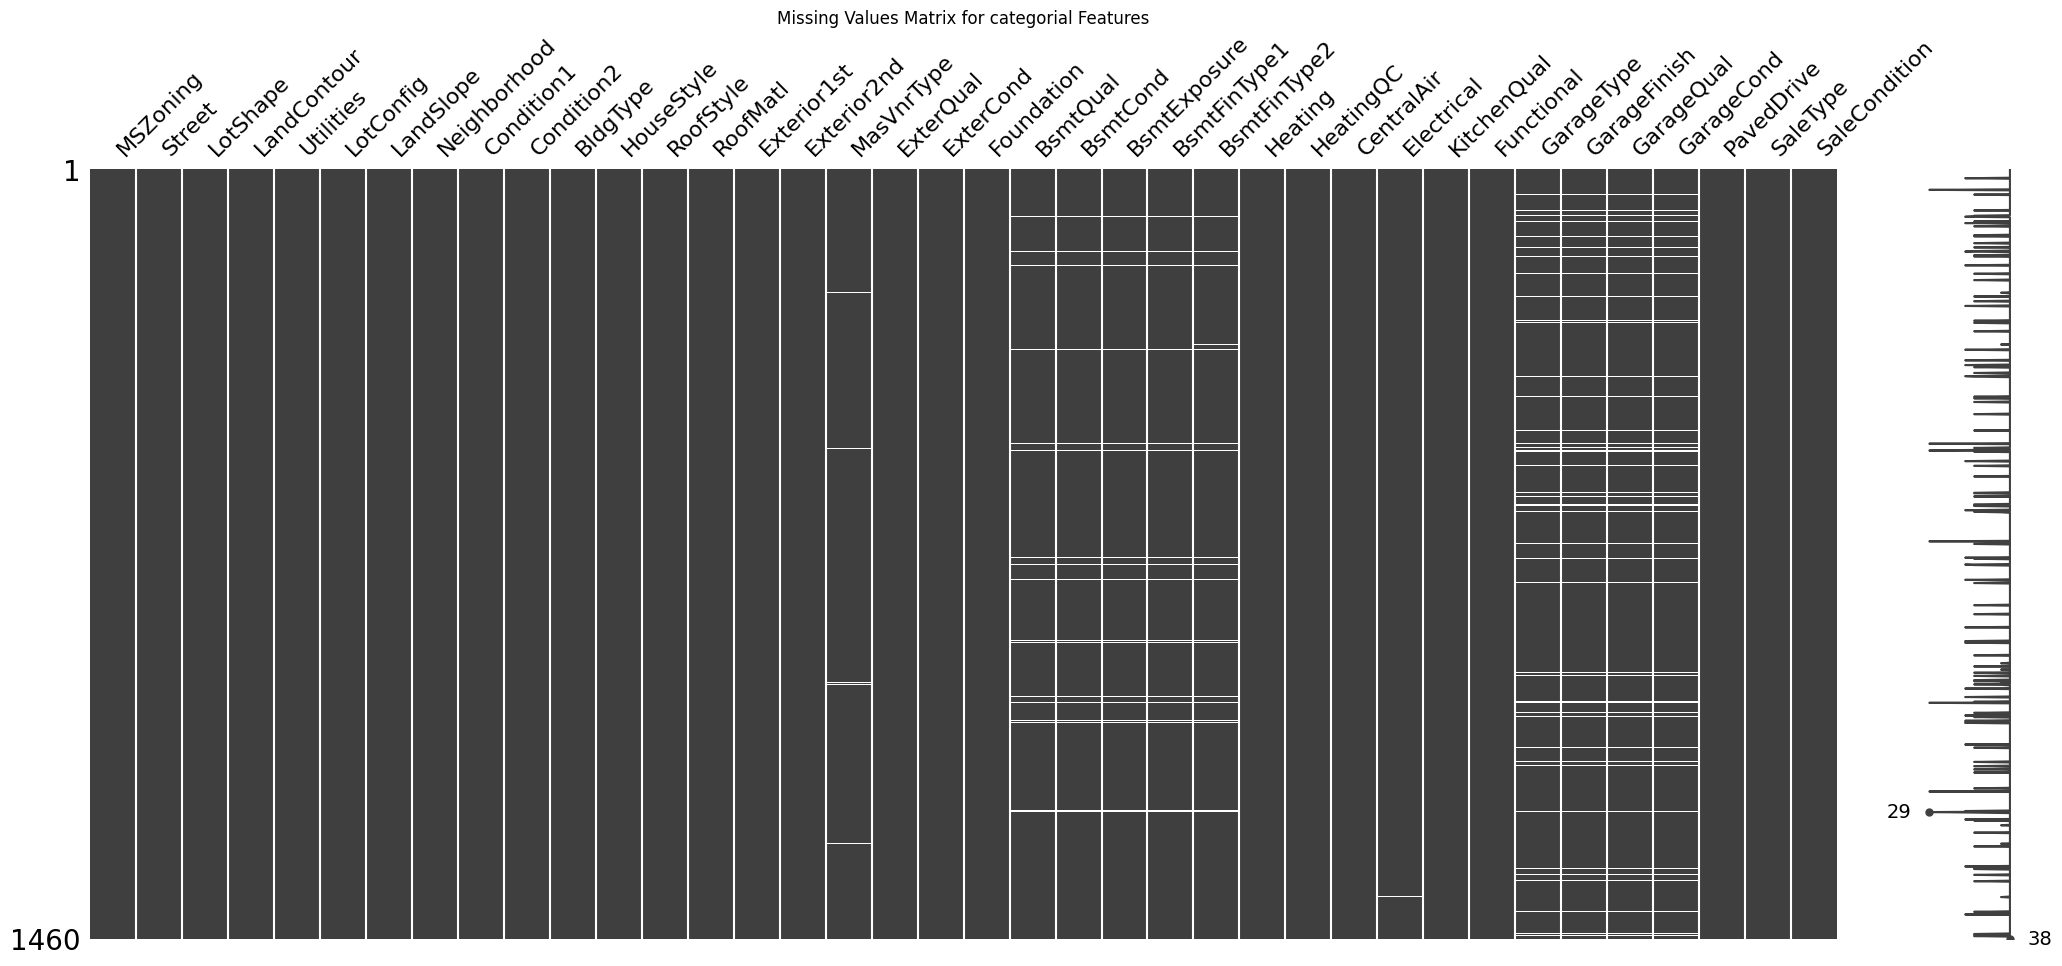

In [390]:
msno.matrix(categorical_features)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

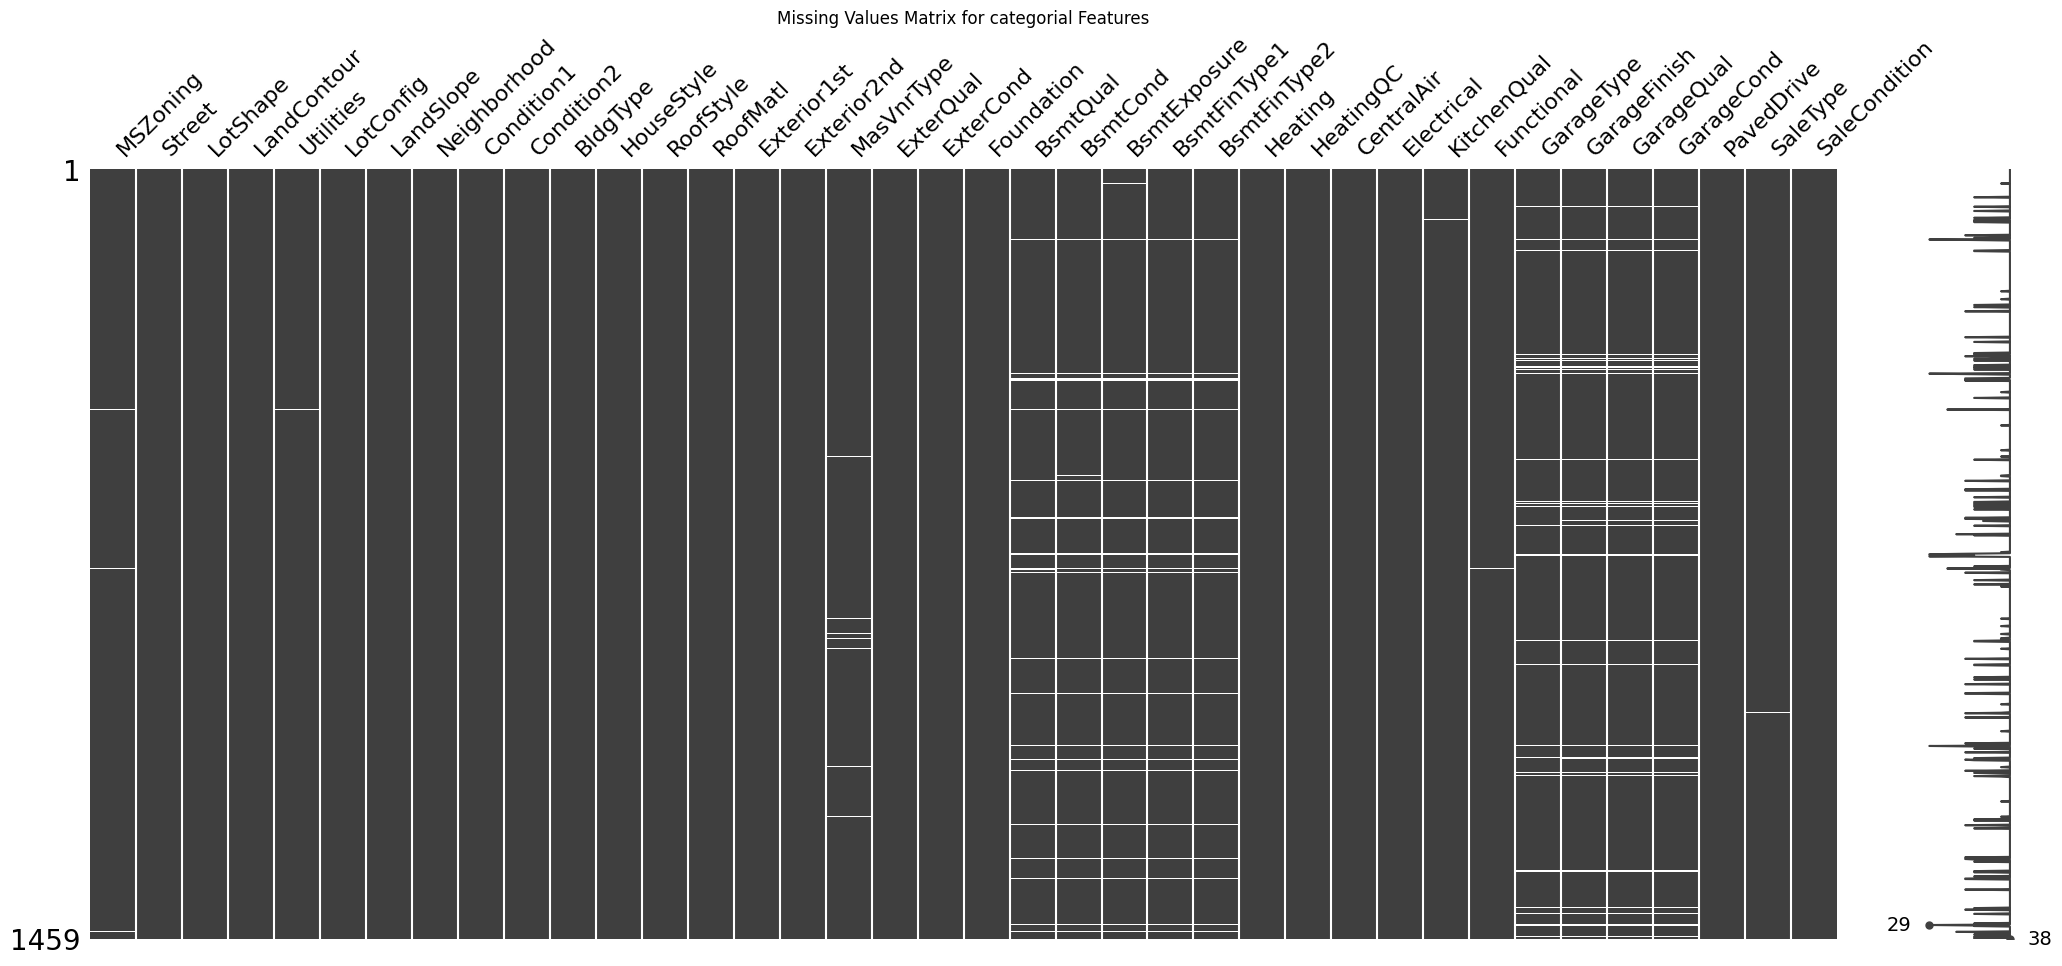

In [391]:
msno.matrix(categorical_features_test)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

### We can see that there are 2 patters of missing values in the categorial data
1. We can notice that  the features the GarageType,GarageFinish,GarageQual, Garagecond  values are missing with the same pattern
2. We can also notice the features related to the basement are missing with the same pattern.
3. The rest of the fetautures has no specfic pattern for the missing values  
4. The features that have the same pattern of missing values belong to the TYPE of MAR
5. The features that does not have the same pattern of missing values belong to the TYPE NMAR
6. we can conclude from the above relaizations, that categorial features missing values are a mix between MAR AND NMAR
7. MAR --> Mutliple Imputation or Regression Imputation
8. NMAR --> Pattern Substition, Maximum Likelihood Estimation  

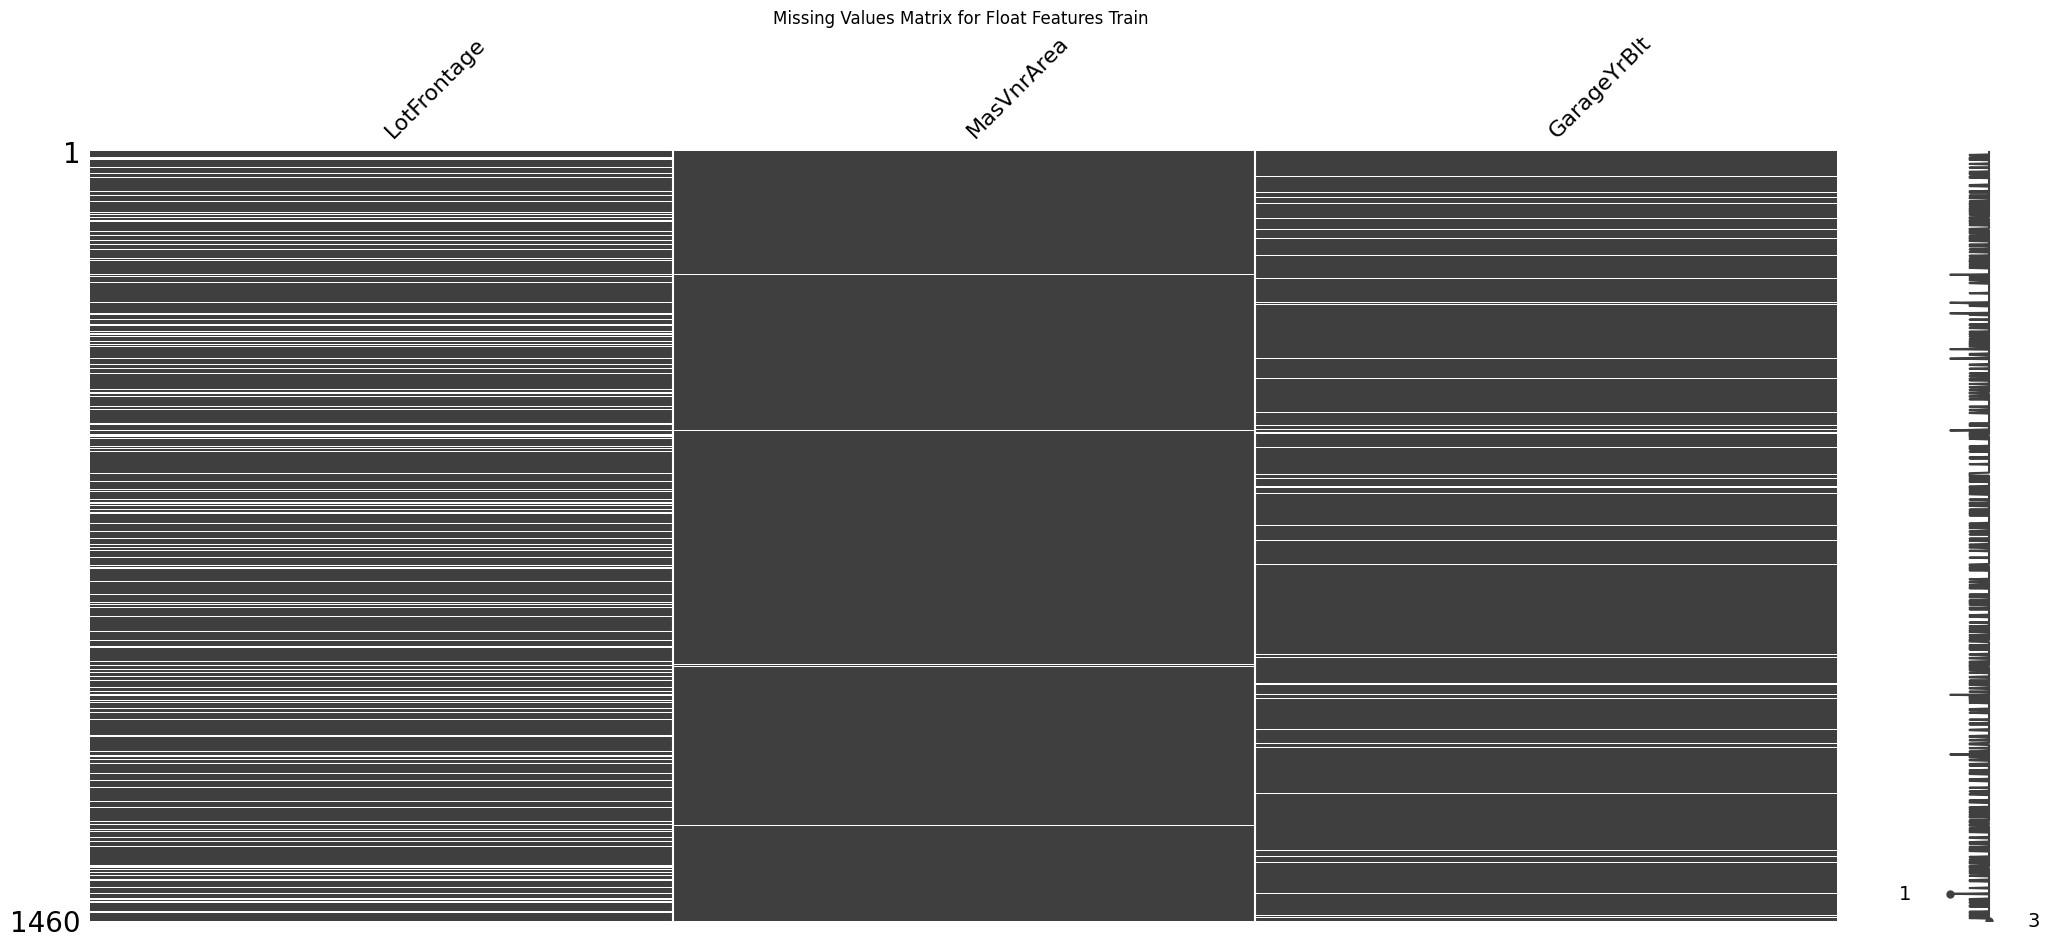

In [392]:
msno.matrix(float_features)
plt.title('Missing Values Matrix for Float Features Train ')
plt.show()

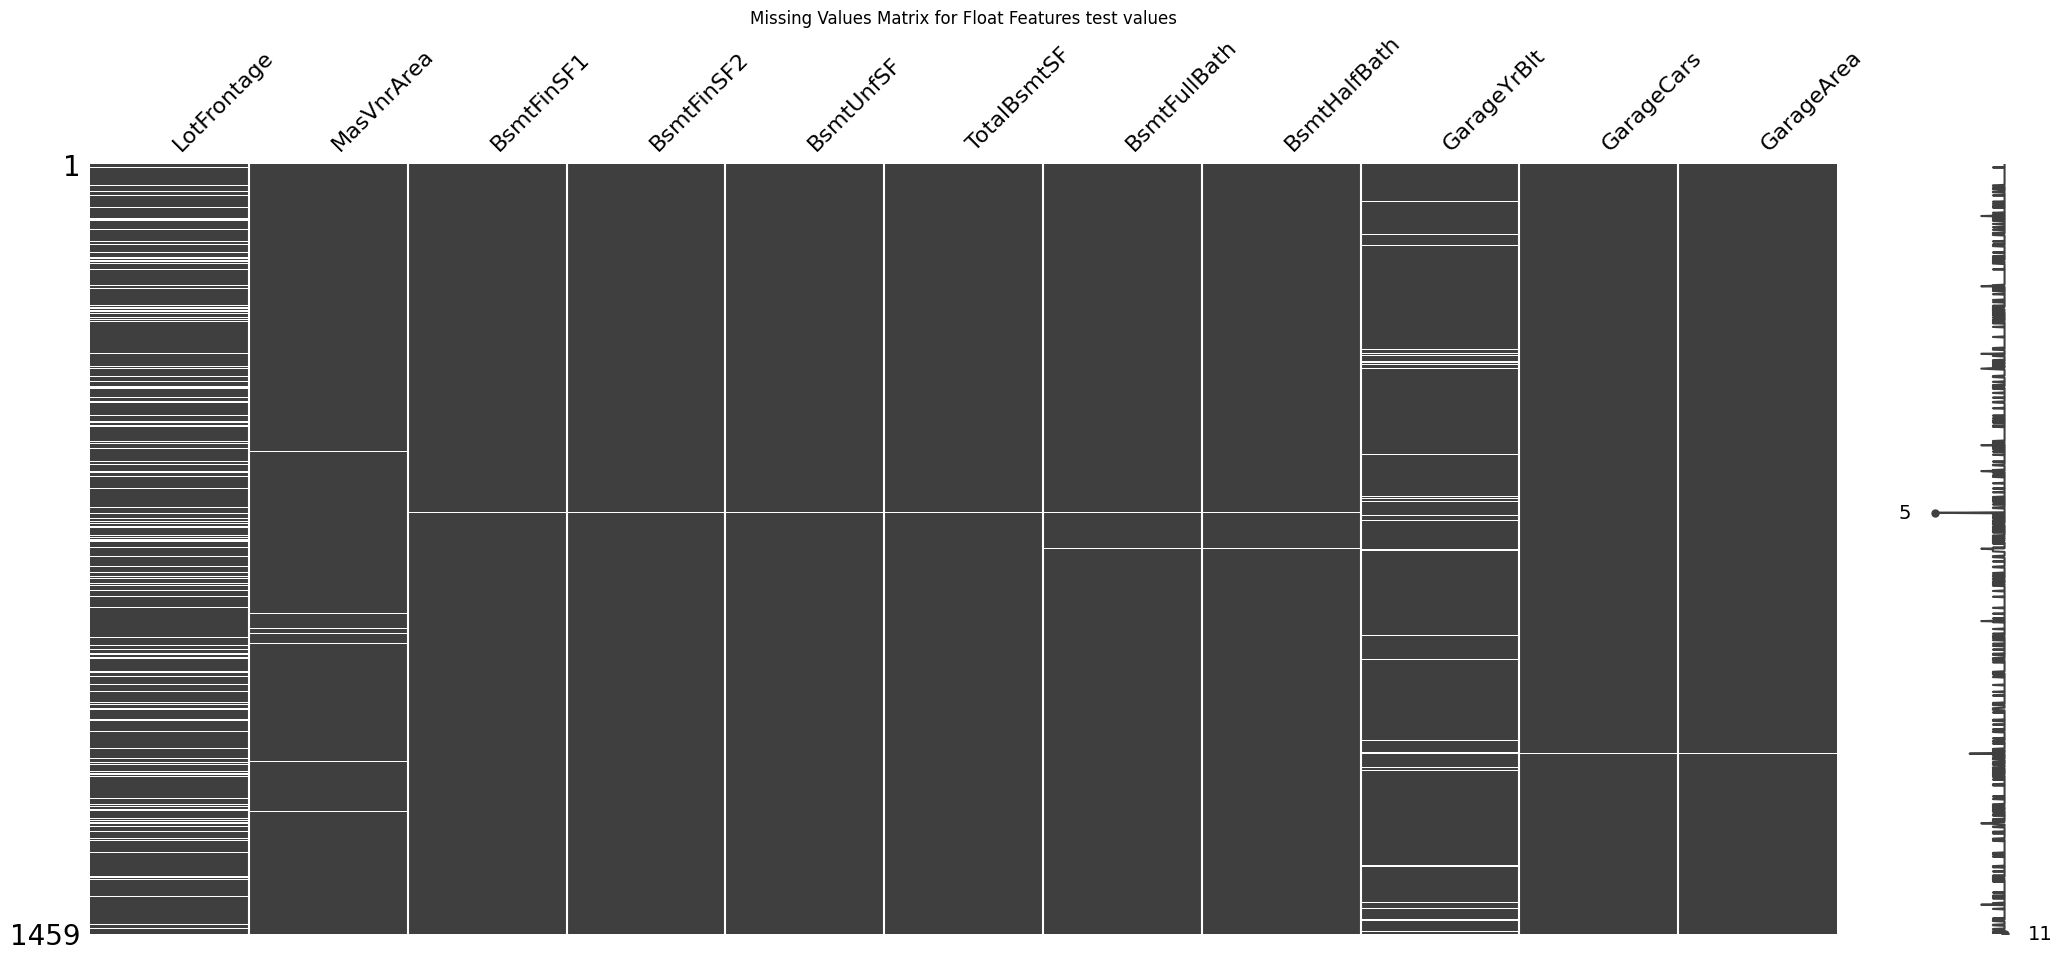

In [393]:
msno.matrix(float_features_test)
plt.title('Missing Values Matrix for Float Features test values')
plt.show()

# In float features, we can notice the following
1. There are no noticable pattern between the missing values
2. The probablity of missing values of feature missing value does not depend on other variables.
3. Thus the float features belong to the MCAR type of missing values
4. MCAR Missing values --> We can apply median imputation 

### Haandling the Missing values and implmenting Imputation Methods

In [435]:
def numerical_imputer(dataframe, numeric_imputer = None ,numeric_scaler= None, strategy='mean', train = True):
    #X_numeric = dataframe.select_dtypes(include=['float64','int64'])
    numeric_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #print(X_numeric.columns)
    if(train == True):
        imputer = SimpleImputer(strategy=strategy)
        scaler = StandardScaler()
        dataframe[numeric_columns] = imputer.fit_transform(dataframe[numeric_columns])
        dataframe[numeric_columns] = scaler.fit_transform(dataframe[numeric_columns])
        return dataframe, imputer, scaler
    else:
        imputer = numeric_imputer
        scaler = numeric_scaler
        dataframe[numeric_columns] = imputer.transform(dataframe[numeric_columns])
        dataframe[numeric_columns] = scaler.transform(dataframe[numeric_columns])  
        return  dataframe      

In [436]:
def categorical_imputer(dataframe,cat_imputer = None, train = True, fill_value='NOT_THERE'):
    categorial_features_nan_meaning = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' , 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    categorial_features_nan_no_meaning =['MasVnrType','Electrical']
    for feature in categorial_features_nan_meaning :
        dataframe[feature] = dataframe[feature].fillna("NOT_THERE")
    if(train == True):
        cat_imputer = SimpleImputer(strategy='most_frequent')
        dataframe[categorial_features_nan_no_meaning] = cat_imputer.fit_transform(dataframe[categorial_features_nan_no_meaning ])
        return dataframe,cat_imputer
    else:
        dataframe[categorial_features_nan_no_meaning] = cat_imputer.transform(dataframe[categorial_features_nan_no_meaning ])
        return dataframe 



In [426]:
def transform_categorial_classes(df, labelencoder,train = True):
    if(labelencoder != None):
        le = labelencoder
    else:       
        le=LabelEncoder()
    for column in df.columns:
        if df[column].dtype=='object':
            df[column]=le.fit_transform(df[column])
    if train == True:        
        return df,le
    else:
        return df        

#df_train,label_encoder = transform_categorial_classes(df_train,None)
#df_test,label_encoder =  transform_categorial_classes(df_test,label_encoder)

In [437]:
def handling_missing_values(dataframe,scaler = None,imputer = None,cat_imputer = None, train = True):
    if(train == True):    
        dataframe, imputer, scaler = numerical_imputer(dataframe)
        dataframe, cat_imputer = categorical_imputer(dataframe)
        #dataframe,label_encoder = transform_categorial_classes(dataframe,None)
        return dataframe, imputer,scaler,cat_imputer
    else:
        dataframe  = numerical_imputer(dataframe,imputer, scaler, train = False)
        dataframe =  categorical_imputer(dataframe,cat_imputer, train = False )
        #dataframe = transform_categorial_classes(dataframe,None,train = False)
        return dataframe
y = df_train['SalePrice'] 
df_train =  df_train.drop(['SalePrice','Id'], axis =1) 
df_test_id = df_test['Id']
df_test =  df_test.drop(['Id'], axis =1)   
df_train,num_imputer,scaler,cat_imputer = handling_missing_values(df_train,scaler = None,imputer = None,cat_imputer = None, train = True)
df_test = handling_missing_values(df_test,scaler,imputer = num_imputer,cat_imputer = cat_imputer, train = False)



In [416]:

imputer = SimpleImputer(strategy='mean')
print("Missing values before imputation:")
print(df_train.isnull().sum())
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
df_train[numeric_columns] = imputer.fit_transform(df_train[numeric_columns])
print("Missing values After imputation:")
print(df_train.isnull().sum())
print(df_train[numeric_columns].isnull().sum())


Missing values before imputation:
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 74, dtype: int64
Missing values After imputation:
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 74, dtype: int64
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Firepl

In [438]:
categorical_features_imputated,numeric_features_imputated,float_features_imputated = features_types(df_train)
categorical_features_test,numeric_features_test,float_features_test = features_types(df_test)

Number of categorial features:38 
Number of numeric features:0
num_of_float_features:36
Number of categorial features:38 
Number of numeric features:0
num_of_float_features:36


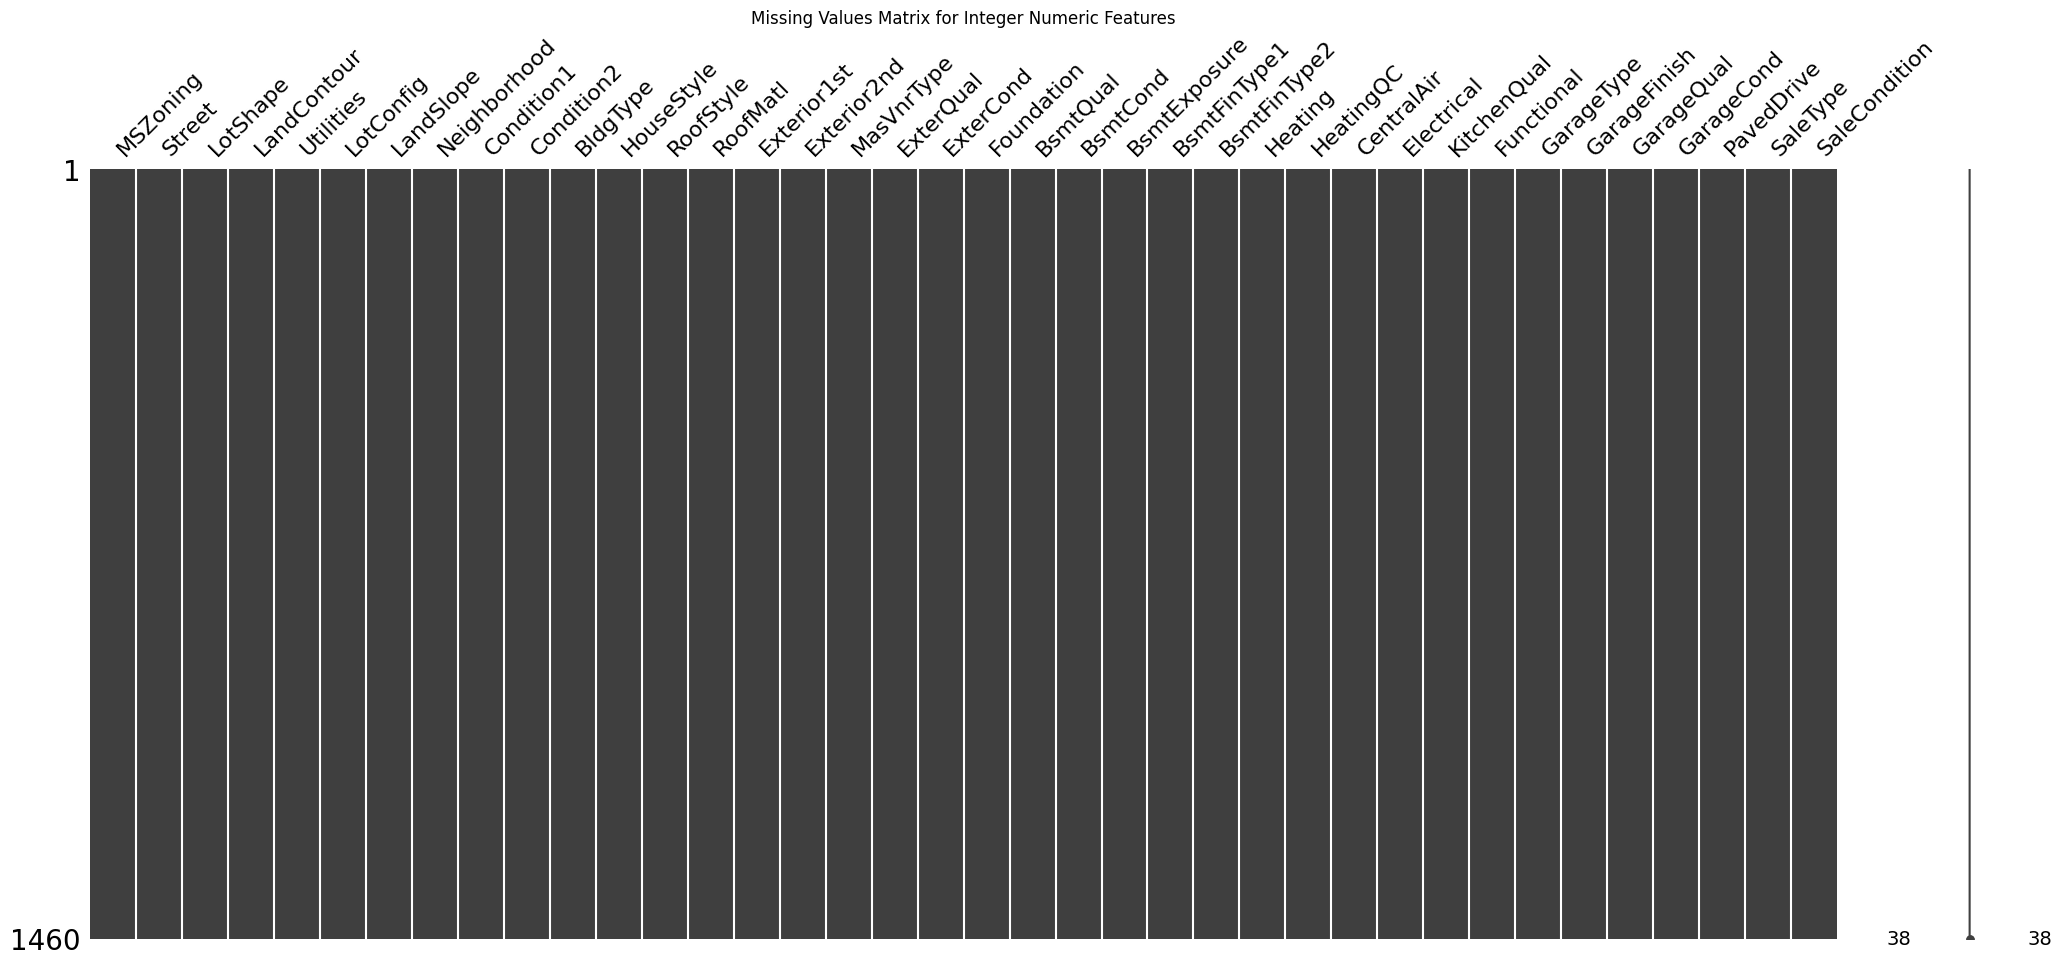

In [439]:
msno.matrix(categorical_features_imputated)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

 

In [440]:
float_features_imputated.isnull().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

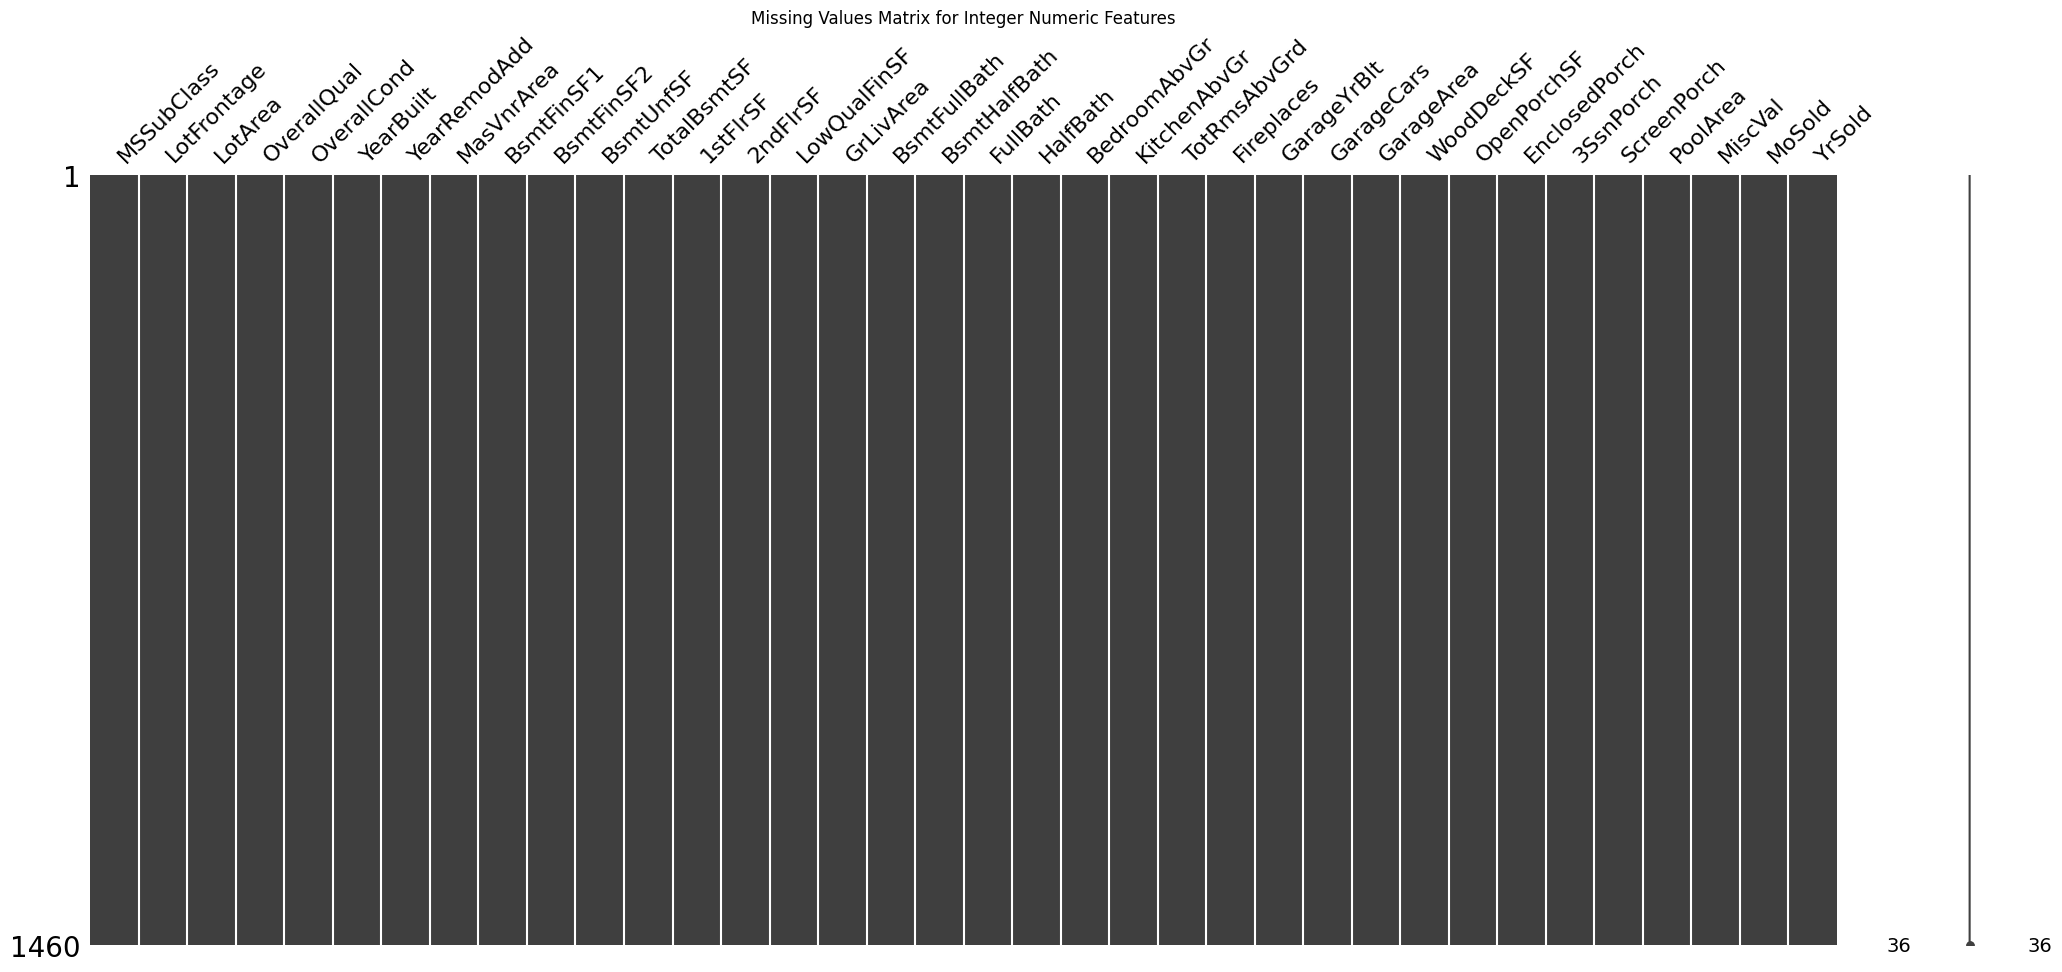

In [441]:
msno.matrix(float_features_imputated)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

In [67]:
unique_values = categorical_features['PoolQC'].unique()
print(unique_values)

[nan 'Ex' 'Fa' 'Gd']


### First after reading the data description, I noticed that the missing values in the data
1. All data that has null values related to the garage and the basement means that they don't have a gargae or a basement 


In [76]:
null_counts = categorical_features['Electrical'].isnull().sum()
print(null_counts)


1


In [236]:
def fill_categorial_features(dataframe):

    categorial_features_nan_meaning = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' , 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    categorial_features_nan_no_meaning =['MasVnrType','Electrical']

    for feature in categorial_features_nan_meaning :
        dataframe[feature] = dataframe[feature].fillna("NOT_THERE")

    for feature in categorial_features_nan_no_meaning:
        mode_value = dataframe[feature].mode()[0]
        dataframe[feature] = dataframe[feature].fillna(mode_value)

    return dataframe

In [181]:
def fill_float_features(dataframe):
    # Check for null values in each column and sum them
    null_counts = float_features.isnull().sum()
    #Filter out columns with non-zero null counts
    columns_with_null = null_counts[null_counts > 0].index.tolist()
    print("Columns with null values:", columns_with_null)
    dataframe[columns_with_null] = dataframe[columns_with_null].fillna(dataframe[columns_with_null].mean())
    return dataframe


In [182]:
def fill_variables(dataframe):
    dataframe = fill_categorial_features(dataframe)
    dataframe = fill_float_features(dataframe)
    return dataframe

df_train = fill_variables(df_train)
df_test  = fill_variables(df_test)

Columns with null values: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Columns with null values: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [183]:
categorical_features,numeric_features,float_features = features_types(df_train)

Number of categorial features:38 
Number of numeric features:35
num_of_float_features:3


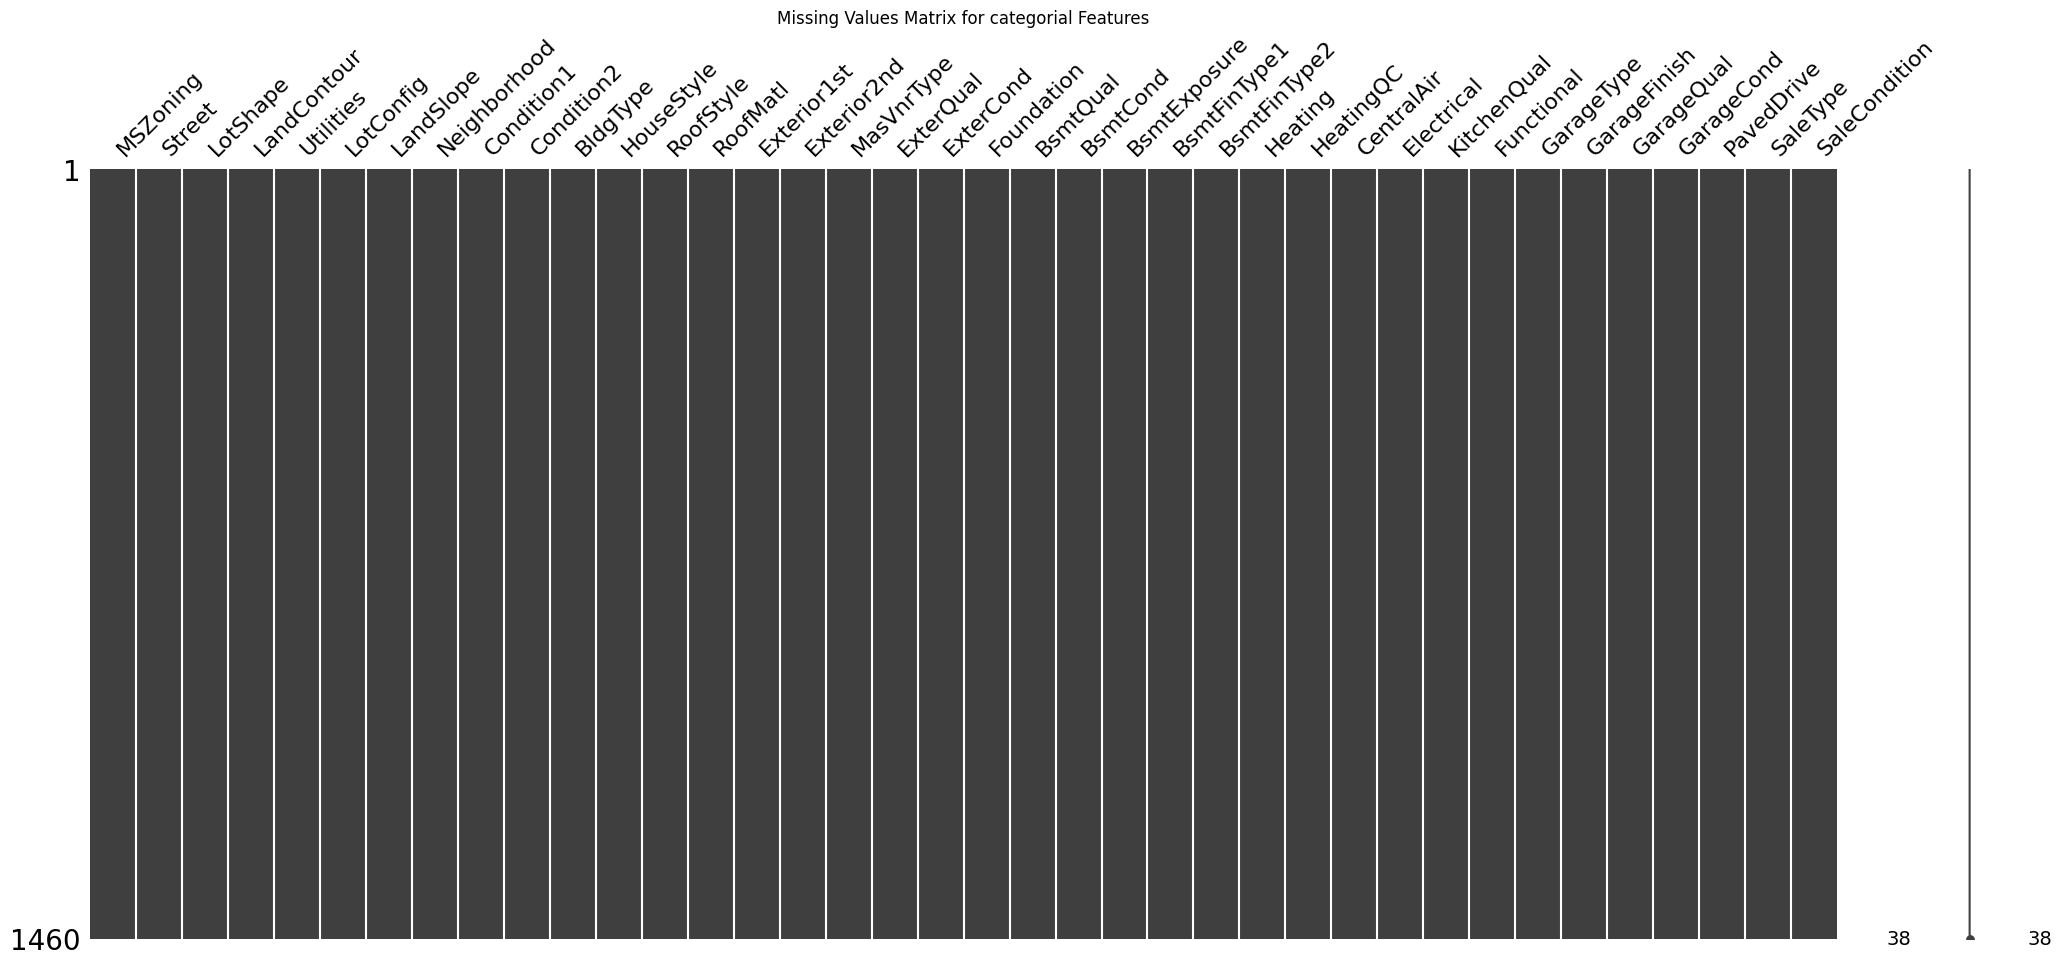

In [184]:
msno.matrix(categorical_features)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

Columns with null values: []


In [86]:
categorical_features,numeric_features,float_features = features_types(df_train)

Number of categorial features:38 
Number of numeric features:35
num_of_float_features:3


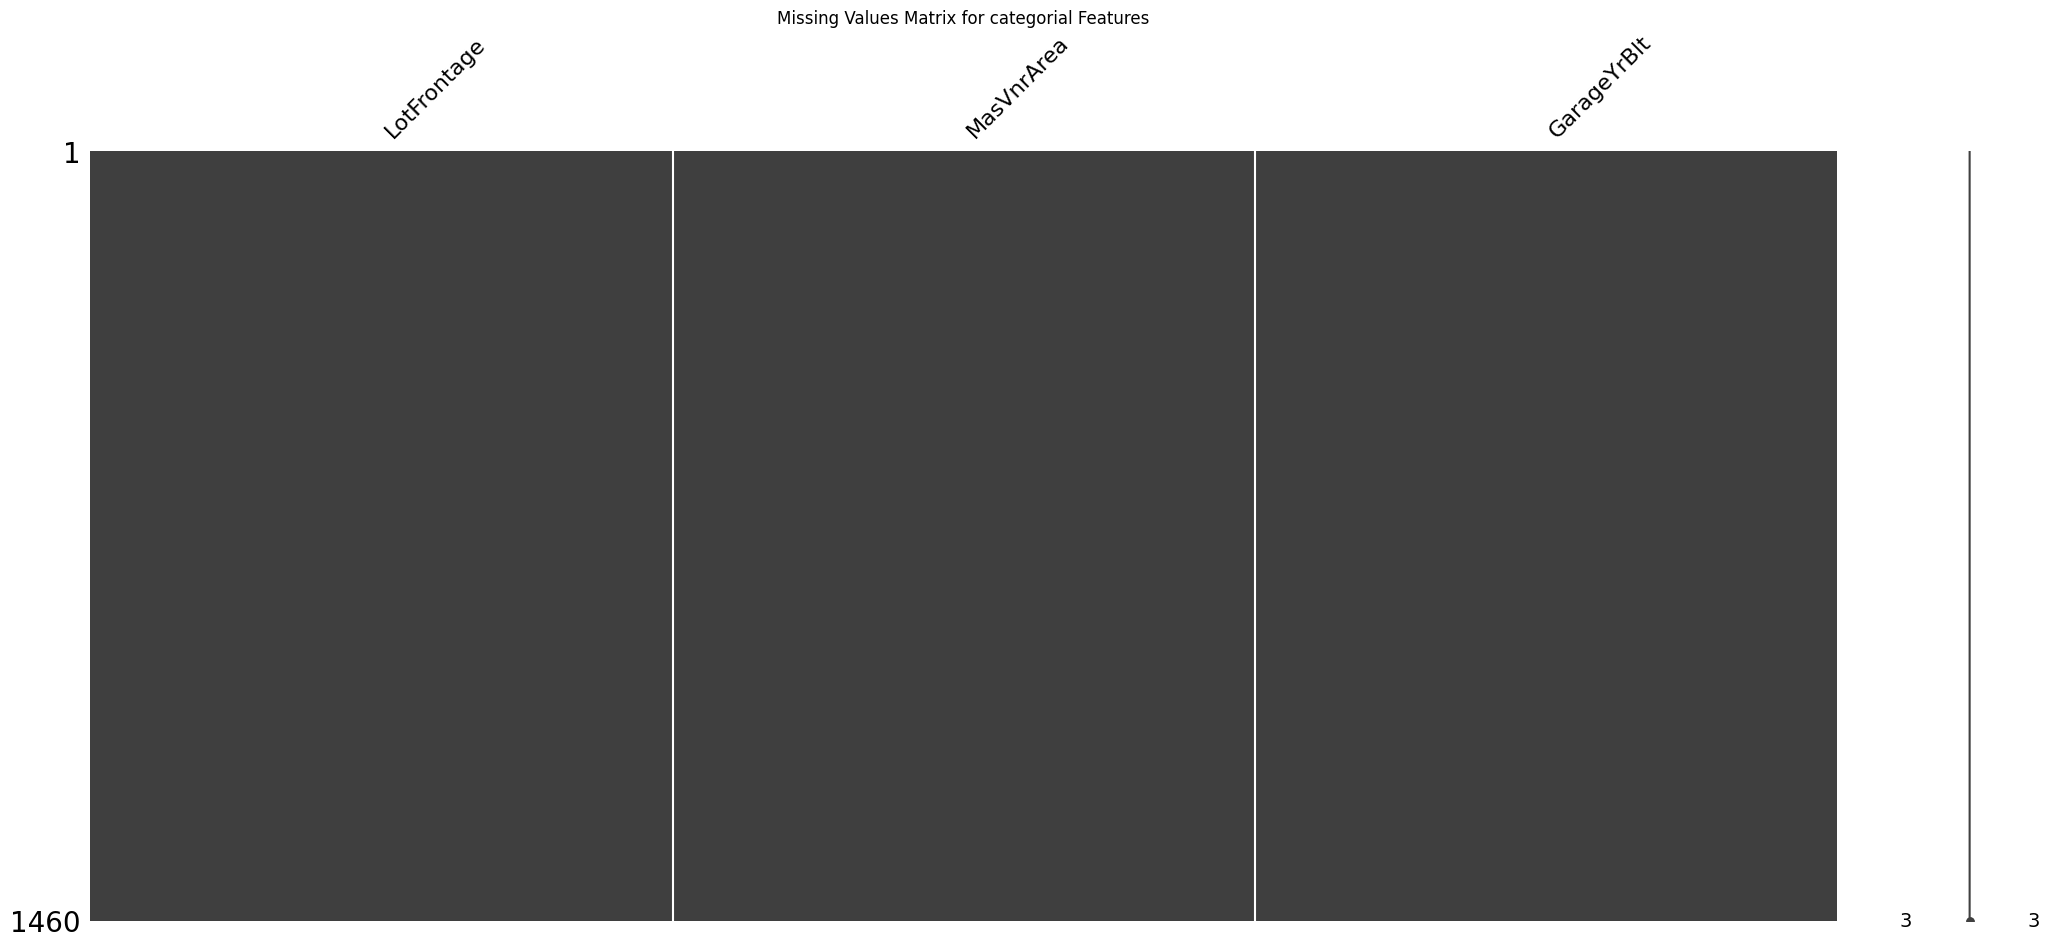

In [185]:
msno.matrix(float_features)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

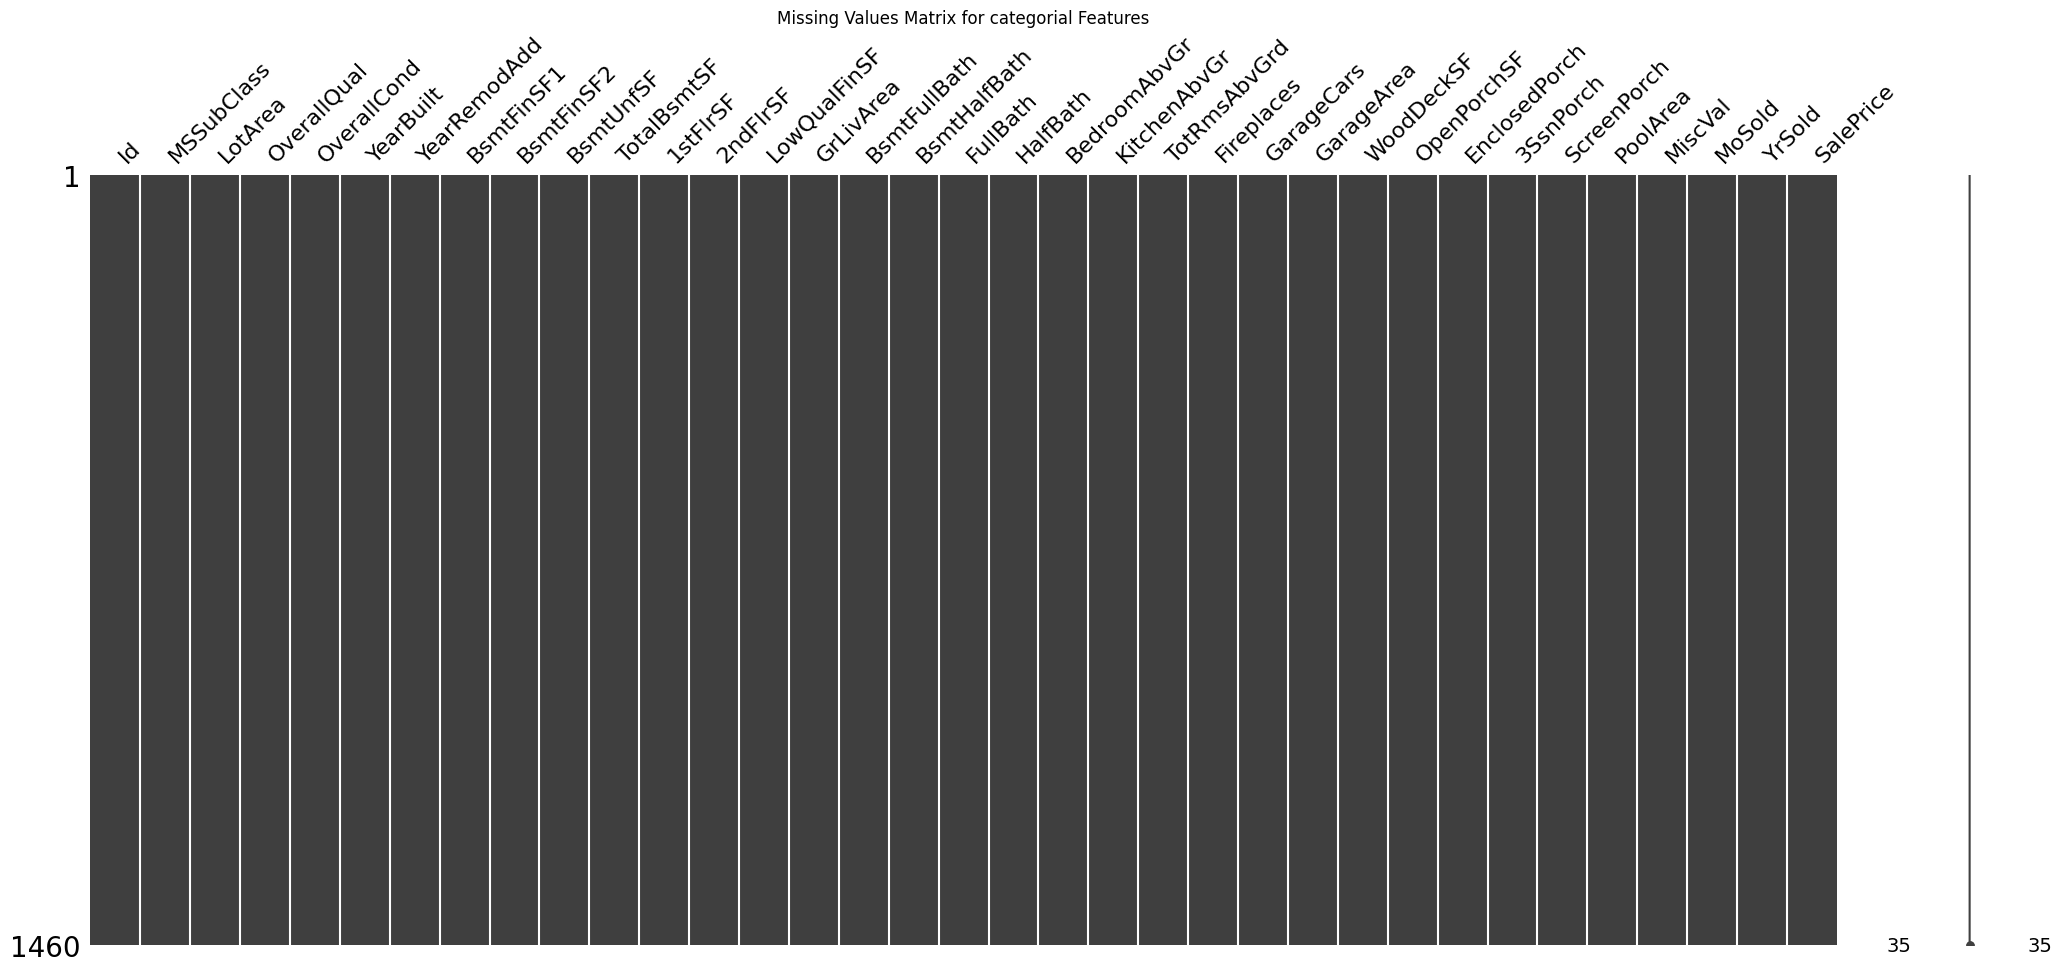

In [186]:
msno.matrix(numeric_features)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

In [443]:
### Transform the categorical classes
df_train,label_encoder = transform_categorial_classes(df_train, labelencoder = None,train = True)
df_test = transform_categorial_classes(df_test, labelencoder = label_encoder,train = False)


In [448]:
import numpy as np
y = np.log(y)
x_train,x_test,y_train,y_test=train_test_split(df_train,y,test_size=0.3,random_state = 42)

In [449]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)
rms = mean_squared_error(y_test, y_pred,squared=False)
print(rms)
acc=lr.score(x_test,y_test)
print(acc)

0.15149566360365443
0.8647129094161976


0.14040327884058246

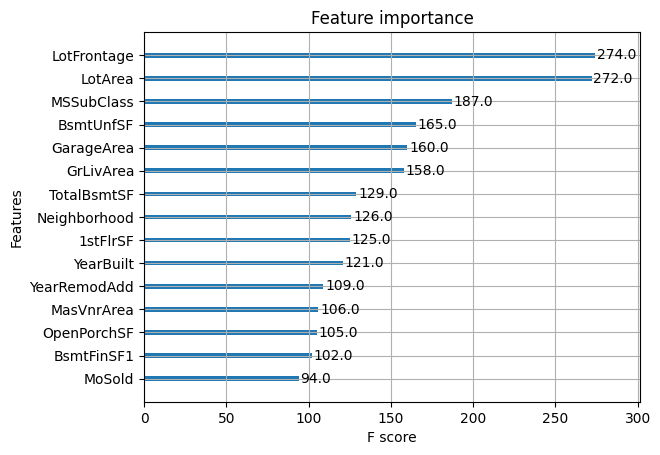

In [451]:
import xgboost
xgb = xgboost.XGBRegressor(objective = 'reg:squarederror')
xgb.fit(x_train, y_train)
xgboost.plot_importance(xgb, max_num_features = 15);
y_pred = xgb.predict(x_test)
mean_squared_error(y_test,y_pred, squared=False)

In [454]:
sales_pred = xgb.predict(df_test)

In [455]:
submission = df = pd.DataFrame({'Id': df_test_id, 'sales_pred': sales_pred})


KeyError: "None of [Float64Index([11.769119262695312, 11.942492485046387, 12.143234252929688,\n              12.177411079406738, 12.029500007629395, 12.073013305664062,\n              11.997377395629883, 12.039258003234863, 12.074913024902344,\n              11.692559242248535,\n              ...\n              11.287572860717773, 11.221142768859863, 11.862055778503418,\n              11.287580490112305, 11.071444511413574,  11.09801197052002,\n              11.213578224182129, 12.013822555541992, 11.672820091247559,\n              12.373869895935059],\n             dtype='float64', length=1459)] are in the [columns]"

In [461]:
submission['sales_pred'] = np.exp(submission['sales_pred'])
submission

,Id,sales_pred
0,1461,129200.312500
1,1462,153659.203125
2,1463,187819.046875
3,1464,194349.046875
4,1465,167627.578125
...,...,...
1454,2915,66039.734375
1455,2916,74130.195312
1456,2917,165020.093750
1457,2918,117338.726562
